In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
from PIL import Image 
import cv2

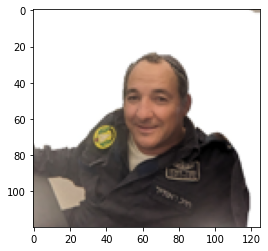

In [4]:
image_path = 'C:\\Users\\bkand\\Downloads\\tanya-images\\ashush_body.jpeg'

with Image.open(image_path) as im: 
    w, h = im.size; ratio = w/h
    im = im.resize((int(ratio*120), 120))
    img = np.asarray(im)
plt.imshow(img)

In [5]:
# Bayers dithering levels
M2 = (1/4) * np.array([
    0, 2, 
    3, 1
]).reshape(2, 2)

M4 = (1/16) * np.array([
    0, 8, 2, 10, 
    12, 4, 14, 6, 
    3, 11, 1, 9, 
    15, 7, 13, 5
]).reshape(4, 4)

M8 = (1/64) * np.array([
    0, 32, 8, 40, 2, 32, 10, 42, 
    48, 16, 56, 24, 50, 18, 58, 26, 
    12, 44, 4, 26, 14, 46, 6, 38, 
    60, 28, 52, 20, 62, 30, 54, 22, 
    3, 35, 11, 43, 1, 33, 9, 41, 
    51, 19, 59, 27, 49, 17, 57, 25, 
    15, 47, 7, 39, 13, 45, 5, 37, 
    63, 31, 55, 23, 61, 29, 53, 21
]).reshape(8, 8)

color_palette = np.array([ 
    [0 ,0 ,0], # black 
    [255, 0, 0], # red
    [0, 255, 0], # green
    [255, 255, 0], # yellow
    [0, 0, 255], # blue
    [255, 0, 255], # magenta
    [255, 255, 255], # white
    [150, 75, 0], # brown
    [0, 127, 127], # cyan50

    [127, 0, 0], # red50
    [0, 127, 0], # green50
    [127, 127, 0], # yellow50
    [0, 0, 127], # blue50
    [127, 0, 127], # magenta50
    [192, 192, 192] # gray75
])

color_palette_names = [ 
    'Black', 'Red', 'Green', 'Yellow', 'Blue', 'Magenta', 'White', 'Brown', 'Cyan50', 'Red50', 'Green50', 'Yellow50', 'Blue50', 'Magenta50', 'Gray75'
]

def nearest_color_palette(c): 
    # quantizing to 16 colors
    c_hat = np.clip((255 * c), 0, 255).astype('uint8')
    err = ((color_palette - c_hat)**2).sum(axis=1)
    idx = np.argmin(err) # the index of minimum error
    return color_palette_names[idx], color_palette[idx]

n = 8 # color num
w, h = img.shape[:2]
r = 1 # 255/n  # spread 

new_img = np.zeros(img.shape)
new_img_img = ''
for x in range(w):
    for y in range(h):
        pixel_name, pixel = nearest_color_palette( (1/255)*img[x, y] + r * M8[x%8, y%8] -.5)
        new_img[x, y] = pixel
        new_img_img += f'Dot {pixel_name}, {x}, {y}\n'

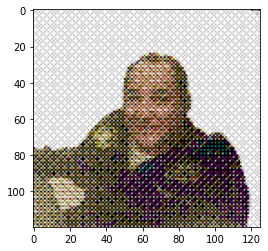

In [6]:
plt.imshow(new_img.astype('uint8'))

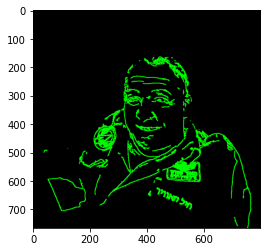

In [ ]:
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# edges_img = cv2.Canny(img, 50, 130)
# controus, hierarchy = cv2.findContours(edges_img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
# output_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8) # 3 channels for color
# # plt.imshow(edges_img)
# cv2.drawContours(output_image, controus[:400], -1, (0, 255, 0), 2)
# plt.imshow(output_image)

# using the hed model



Found 386 raw contours.

--- Detected Line Segments ---

Total vectorized line segments: 5273


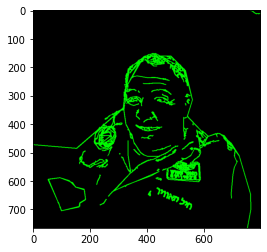

In [8]:
import cv2
import numpy as np

def vectorize_black_white_image(image_path, output_filename="vectorized_output.png", min_area_threshold=1, epsilon_factor=0.02):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Could not load image from {image_path}. Please check the path.")
        return

    edge_detection_image = cv2.Canny(img, 50, 150)
    # cv2.RETR_EXTERNAL retrieves only the extreme outer contours.
    contours, hierarchy = cv2.findContours(edge_detection_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Found {len(contours)} raw contours.")

    # Prepare an empty image to draw the vectorized lines on for visualization
    output_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8) # 3 channels for color

    print("\n--- Detected Line Segments ---")
    vectorized_lines = []

    # 3. Process and simplify each contour
    for i, contour in enumerate(contours):
        # Filter out small contours which might be noise
        area = cv2.contourArea(contour)
        if area < min_area_threshold:
            # print(f"Skipping small contour {i} with area {area}")
            continue

        # Calculate epsilon based on contour perimeter for approxPolyDP
        # epsilon is the maximum distance between the original contour and its approximation.
        perimeter = cv2.arcLength(contour, True)
        epsilon = epsilon_factor * perimeter
        
        # Approximate the contour with a polygon (Ramer-Douglas-Peucker algorithm)
        # This reduces the number of points while maintaining the general shape.
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # Draw the simplified polygon on the output image
        # color is green (0, 255, 0)
        color = (255, 0, 0) if hierarchy[0][i][3] == -1 else  (0,255,0)
        color = (0, 255, 0)
        cv2.drawContours(output_image, [approx], -1, color, 2)
        
        # Store the line segments
        # Each point in 'approx' is a vertex of the simplified polygon.
        # We connect consecutive points to form line segments.
        # print(f"Contour {i} (Area: {area:.2f}, Simplified points: {len(approx)}):")
        for j in range(len(approx)):
            p1 = approx[j][0]
            p2 = approx[(j + 1) % len(approx)][0] # Connect last point to first for closed contour
            line_segment = (tuple(p1), tuple(p2))
            vectorized_lines.append(line_segment)
            # print(f"  Line from {line_segment[0]} to {line_segment[1]}")
        # print("-" * 30)

    if not vectorized_lines:
        print("No significant line segments found. Try adjusting thresholds or use a clearer image.")

    print(f"\nTotal vectorized line segments: {len(vectorized_lines)}")

    # 4. Display the results
    # Resize images for better display if they are very large
    display_width = 800
    original_display_img = cv2.resize(img, (display_width, int(img.shape[0] * display_width / img.shape[1])))
    output_display_img = cv2.resize(output_image, (display_width, int(output_image.shape[0] * display_width / output_image.shape[1])))


    # cv2.imshow("Original Black and White Image", original_display_img)
    # cv2.imshow("Vectorized Lines (Green)", output_display_img)
    # cv2.imshow("edge detection on image", edge_detection_image)
    plt.imshow(output_display_img)
    
    # Save the vectorized output image
    # cv2.imwrite(output_filename, output_image)
    # print(f"\nVectorized output image saved as '{output_filename}'")

    # print("Press any key to close the image windows...")
    cv2.waitKey(0) # Waits indefinitely for a key press
    cv2.destroyAllWindows() # Closes all OpenCV windows

# --- How to use the function ---
if __name__ == "__main__":
    vectorize_black_white_image(image_path, min_area_threshold=1, epsilon_factor=0.005)

In [ ]:
# convert to Video Generator Format (file called face.img)

with open('face.img', '+a') as face_img: 
    face_img.write(new_img_img)

In [ ]:
# for i in range(43):
#   v1, v2 = hex((0x150 - i*16) & 0x7fff), hex((0x148-i*16)&0x7fff)
#   print(0x150 - i*16, 0x148-i*16)
#   print(f'0x7eab, {v1},')
#   print(f'0x8155, {v1},')
#   print(f'0x0155, {v2},')
#   print(f'0xfeab, {v2},')

In [ ]:
0x8000 -31908

In [ ]:
# l1: (-859, 1600) (-859, 31169[1599])
# l2: ( 860, 1600) (-31908[-860] 31169[1599])
# l3: (31169[1599], 860) (-31168[-1600], 860)
# l4: (31169[1599], 0) (-429, 0)
# l5: (31169[1599] 31909[-859]) (-31168[-1600] 31909[-859])
# l6: ()